In [1]:
# https://mf1024.github.io/2019/06/22/Create-Pytorch-Datasets-and-Dataloaders/
# How to create and use custom pytorch Dataset from the Imagenet

from torch.utils.data import DataLoader

#from dataset import *
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
import time
IMG_SIZE = (128,128)
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

BATCH_SIZE=32

In [2]:
COCO_path = {

    'path': '/media/jake/mark-4tb3/input/datasets/coco',
    'train': '/media/jake/mark-4tb3/input/datasets/coco/train2017',
    'test': '/media/jake/mark-4tb3/input/datasets/coco/test2017',
    'path2json': '/media/jake/mark-4tb3/input/datasets/coco/instances_train2017.json',
    'save_images': '/media/jake/mark-4tb3/input/datasets/coco/images/'
}

In [3]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):

        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [4]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
cocod_dataset = CocoDataset(COCO_path['train'],COCO_path['path2json'])
#train = cocod_dataset.get_train()
#cocod.draw_box(train,6)


# own DataLoader
data_loader = torch.utils.data.DataLoader(cocod_dataset,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

loading annotations into memory...
Done (t=12.40s)
creating index...
index created!


In [17]:
def draw_box(img,target):
    #img,target = train[num]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    blue_color = (255, 0, 0)
    img = np.array(img)
    for i in range(len(target)):
        bbox = target[i]
        x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        x, y, w, h = int(x), int(y), int(w), int(h)
        img_bbox = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    im = Image.fromarray(img_bbox)
    im.save("your_file.jpeg")

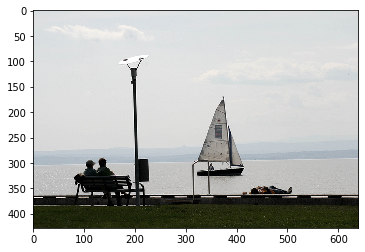

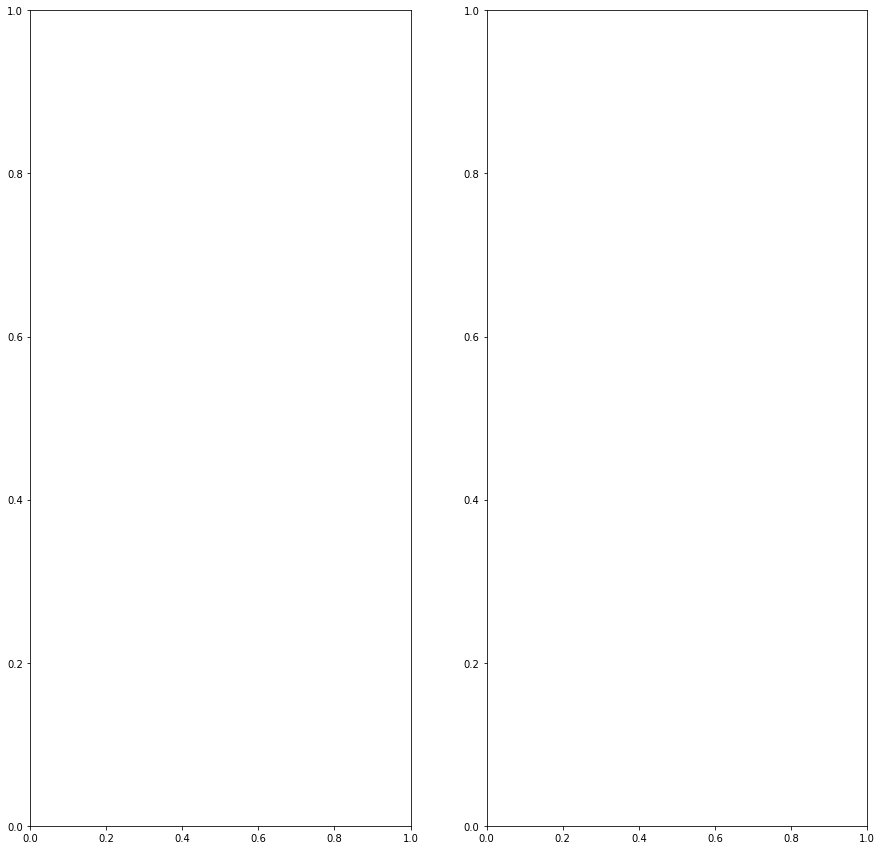

In [18]:
for imgs, annotations in data_loader:
    #toTensor = torchvision.transforms.ToTensor()
    
    #imgs = list(toTensor(img).to(device) for img in imgs)
    
    #annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    target = annotations[0]['boxes'].tolist()
    
    img = imgs[0]
    plt.imshow(img)
    draw_box(img,target)
    break